# Interpretable Modelling of Credit Risk

Luopeiwen Yi

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

In [7]:
import pandas as pd
import numpy as np
import patsy
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import pygam
from pygam import LogisticGAM, s, f
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

> There are two "EDUCATION_LEVEL" columns in the dataframe. To better distingush them, I name the 1st one "EDUCATION_LEVEL" and the 2nd one "EDUCATION_LEVEL_2"

In [8]:
modeling_data = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt",
    header=None,
    delimiter="\t",
    encoding="latin1",
)
modeling_data.columns = [
    "ID_CLIENT",
    "CLERK_TYPE",
    "PAYMENT_DAY",
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "POSTAL_ADDRESS_TYPE",
    "SEX",
    "MARITAL_STATUS",
    "QUANT_DEPENDANTS",
    "EDUCATION_LEVEL",
    "STATE_OF_BIRTH",
    "CITY_OF_BIRTH",
    "NACIONALITY",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "FLAG_RESIDENCIAL_PHONE",
    "RESIDENCIAL_PHONE_AREA_CODE",
    "RESIDENCE_TYPE",
    "MONTHS_IN_RESIDENCE",
    "FLAG_MOBILE_PHONE",
    "FLAG_EMAIL",
    "PERSONAL_MONTHLY_INCOME",
    "OTHER_INCOMES",
    "FLAG_VISA",
    "FLAG_MASTERCARD",
    "FLAG_DINERS",
    "FLAG_AMERICAN_EXPRESS",
    "FLAG_OTHER_CARDS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_SPECIAL_BANKING_ACCOUNTS",
    "PERSONAL_ASSETS_VALUE",
    "QUANT_CARS",
    "COMPANY",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "FLAG_PROFESSIONAL_PHONE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "MONTHS_IN_THE_JOB",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
    "MATE_PROFESSION_CODE",
    "EDUCATION_LEVEL_2",
    "FLAG_HOME_ADDRESS_DOCUMENT",
    "FLAG_RG",
    "FLAG_CPF",
    "FLAG_INCOME_PROOF",
    "PRODUCT",
    "FLAG_ACSP_RECORD",
    "AGE",
    "RESIDENCIAL_ZIP_3",
    "PROFESSIONAL_ZIP_3",
    "TARGET_LABEL_BAD=1",
]

modeling_data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

> Based on the documentations, "QUANT_ADDITIONAL_CARDS", "RESIDENCE_TYPE", "MONTHS_IN_RESIDENCE", "FLAG_OTHER_CARDS", "OCCUPATION_TYPE" has unique category NULL. replace NULL with np.nan to mark them as missing values.

In [9]:
# Replace "NULL" strings with np.nan to mark them as missing values
modeling_data.replace("NULL", np.nan, inplace=True)

> Drop columns with more than 50% missing values

In [10]:
# Calculate the percentage of missing values for each column
missing_percent = modeling_data.isnull().mean()

# Identify columns with more than 50% missing values
columns_to_drop = missing_percent[missing_percent > 0.5].index.tolist()

# Print columns to drop
print(f"Columns to drop due to more than 50% missing values: {columns_to_drop}")

Columns to drop due to more than 50% missing values: ['PROFESSIONAL_CITY', 'PROFESSIONAL_BOROUGH', 'MATE_PROFESSION_CODE', 'EDUCATION_LEVEL_2']


In [11]:
# Drop these columns from the DataFrame
modeling_data = modeling_data.drop(columns=columns_to_drop)

> Inspect any unobvious missing variables in the dataframe.

In [12]:
# Iterate through each column in the DataFrame
for column in modeling_data.columns:
    print(f"Column: {column}")
    print(f"Data type: {modeling_data[column].dtype}")

    # Print unique values for each column. Convert to string to ensure np.nan is included
    unique_values = (
        modeling_data[column].astype(str).unique()
    )  # Converts np.nan to 'nan'
    print(f"Unique categories : {unique_values}")

    # Print a separator for readability
    print("-" * 40)

Column: ID_CLIENT
Data type: int64
Unique categories : ['1' '2' '3' ... '49998' '49999' '50000']
----------------------------------------
Column: CLERK_TYPE
Data type: object
Unique categories : ['C']
----------------------------------------
Column: PAYMENT_DAY
Data type: int64
Unique categories : ['5' '15' '20' '10' '25' '1']
----------------------------------------
Column: APPLICATION_SUBMISSION_TYPE
Data type: object
Unique categories : ['Web' 'Carga' '0']
----------------------------------------
Column: QUANT_ADDITIONAL_CARDS
Data type: int64
Unique categories : ['0']
----------------------------------------
Column: POSTAL_ADDRESS_TYPE
Data type: int64
Unique categories : ['1' '2']
----------------------------------------
Column: SEX
Data type: object
Unique categories : ['F' 'M' 'N' ' ']
----------------------------------------
Column: MARITAL_STATUS
Data type: int64
Unique categories : ['6' '2' '1' '5' '3' '7' '4' '0']
----------------------------------------
Column: QUANT_DEPEND

> There are "N", " "in some varaibles which indicates missing values. Caculate the percentage of missingness for each of them.

In [13]:
columns = [
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "SEX",
    "MARITAL_STATUS",
    "EDUCATION_LEVEL",
    "RESIDENCE_TYPE",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
]


def calculate_missing_rate(column, data):
    # Initialize missing_count to 0
    missing_count = 0

    if data[column].dtype == "object":
        # For strings, consider 'N', ' ' as missing.
        missing_count = data[column].isin(["N", " "]).sum()
    else:
        missing_count = data[column].isna().sum()

    # Calculate the missing rate
    missing_rate = missing_count / len(data) * 100
    return missing_rate


# Iterate over the specified columns and print their missing rates
for column in columns:
    missing_rate = calculate_missing_rate(column, modeling_data)
    print(f"Missing rate for {column}: {missing_rate:.2f}%")

Missing rate for APPLICATION_SUBMISSION_TYPE: 0.00%
Missing rate for QUANT_ADDITIONAL_CARDS: 0.00%
Missing rate for SEX: 0.13%
Missing rate for MARITAL_STATUS: 0.00%
Missing rate for EDUCATION_LEVEL: 0.00%
Missing rate for RESIDENCE_TYPE: 2.70%
Missing rate for PROFESSIONAL_STATE: 68.61%
Missing rate for PROFESSIONAL_PHONE_AREA_CODE: 73.06%
Missing rate for PROFESSION_CODE: 15.51%
Missing rate for OCCUPATION_TYPE: 14.63%


> According to the percentage count, it shows that "PROFESSIONAL_STATE", and "PROFESSIONAL_PHONE_AREA_CODE" has more than 50% missing rate.

In [14]:
columns_to_drop = [
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_PHONE_AREA_CODE",
]

# Drop the specified columns from the DataFrame
modeling_data = modeling_data.drop(columns=columns_to_drop)

# Verify the columns have been dropped
modeling_data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


> In the end, I decided to drop 'PROFESSIONAL_CITY', 'PROFESSIONAL_BOROUGH', 'MATE_PROFESSION_CODE', 'EDUCATION_LEVEL_2', 'PROFESSIONAL_STATE', and 'PROFESSIONAL_PHONE_AREA_CODE' due to more than 50% missing values rate.

### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [15]:
final_variables = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
    "TARGET_LABEL_BAD=1",
]

final_model = modeling_data[final_variables]

final_model.head()

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,SEX,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,RESIDENCIAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,0,15.0,900.0,0,32,F,6,4.0,1.0,RN,Santana do Matos,Centro,595,1
1,0,0,1.0,750.0,0,34,F,2,4.0,1.0,RJ,RIO DE JANEIRO,CAMPO GRANDE,230,1
2,0,0,NaN,500.0,0,27,F,2,NaN,1.0,RN,Parnamirim,Boa Esperanca,591,0
3,0,0,NaN,500.0,0,61,F,2,NaN,NaN,PE,CABO,PONTE DOS CARVALHOS,545,0
4,0,0,12.0,1200.0,0,48,M,2,5.0,1.0,RJ,Rio de Janeiro,Santa Cruz,235,1


In [16]:
# drop na values in the final model
final_model = final_model.dropna()

> Perform Variable Cleaning for Predictor Variables

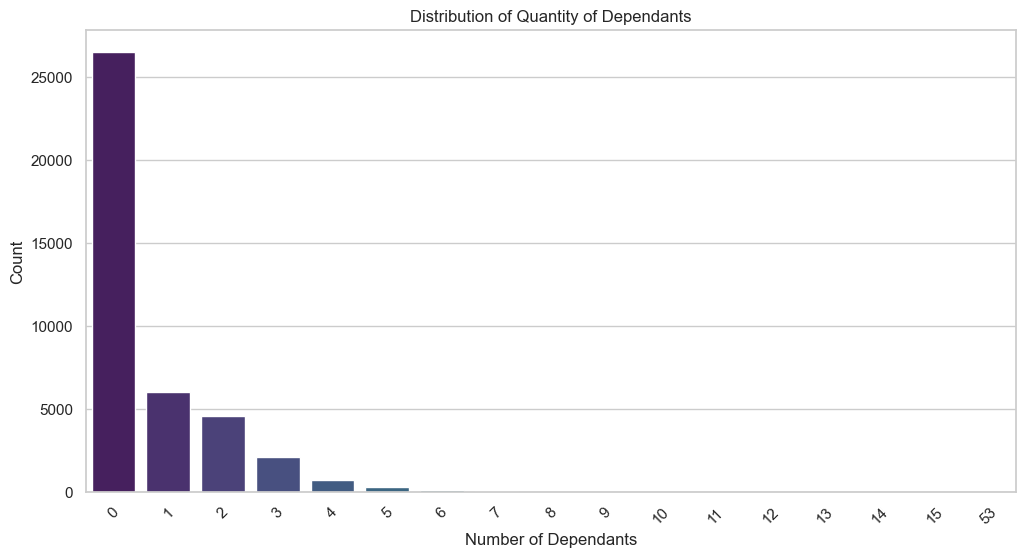

In [18]:
# Plot QUANT_DEPENDANTS
sns.set(style="whitegrid")

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(x="QUANT_DEPENDANTS", data=final_model, palette="viridis")
plt.title("Distribution of Quantity of Dependants")
plt.xlabel("Number of Dependants")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Show the plot
plt.show()

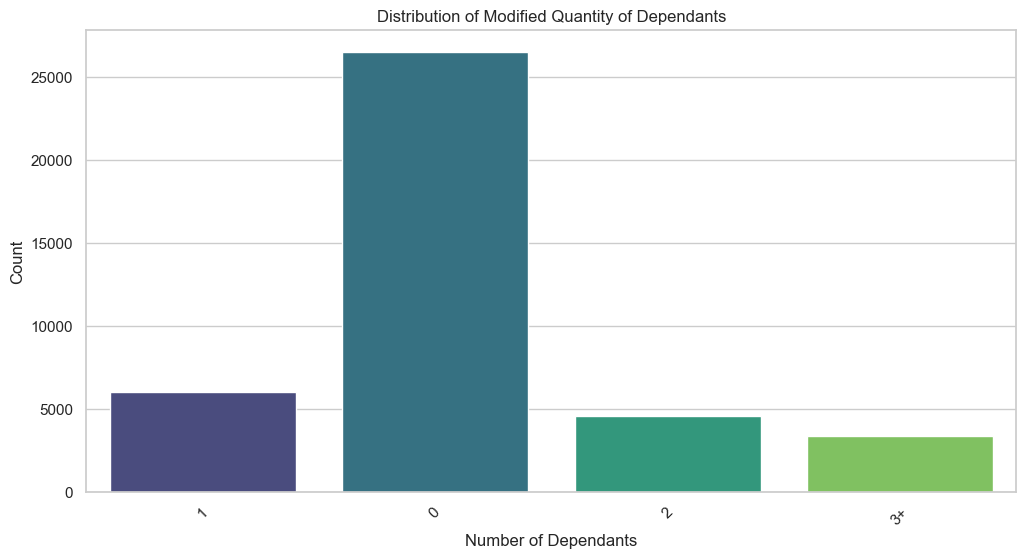

In [19]:
# Create a new quant dependants variable with 3+ a one unique category
final_model["NEW_QUANT_DEPENDANTS"] = final_model["QUANT_DEPENDANTS"].apply(
    lambda x: str(x) if x < 3 else "3+"
)

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(x="NEW_QUANT_DEPENDANTS", data=final_model, palette="viridis")
plt.title("Distribution of Modified Quantity of Dependants")
plt.xlabel("Number of Dependants")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Show the plot
plt.show()

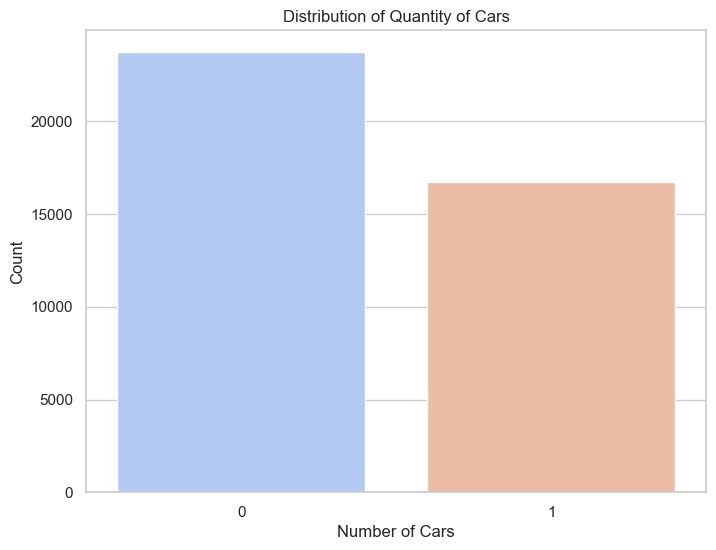

In [20]:
# Plot QUANT_CARS
sns.set(style="whitegrid")

# Plotting with seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x="QUANT_CARS", data=final_model, palette="coolwarm")
plt.title("Distribution of Quantity of Cars")
plt.xlabel("Number of Cars")
plt.ylabel("Count")
plt.xticks([0, 1])

# Show the plot
plt.show()

In [21]:
# remove rows in MONTHS_IN_RESIDENCE where the value is the string 'nan'
final_model = final_model[final_model["MONTHS_IN_RESIDENCE"] != "nan"]
final_model["MONTHS_IN_RESIDENCE"] = final_model["MONTHS_IN_RESIDENCE"].astype(int)

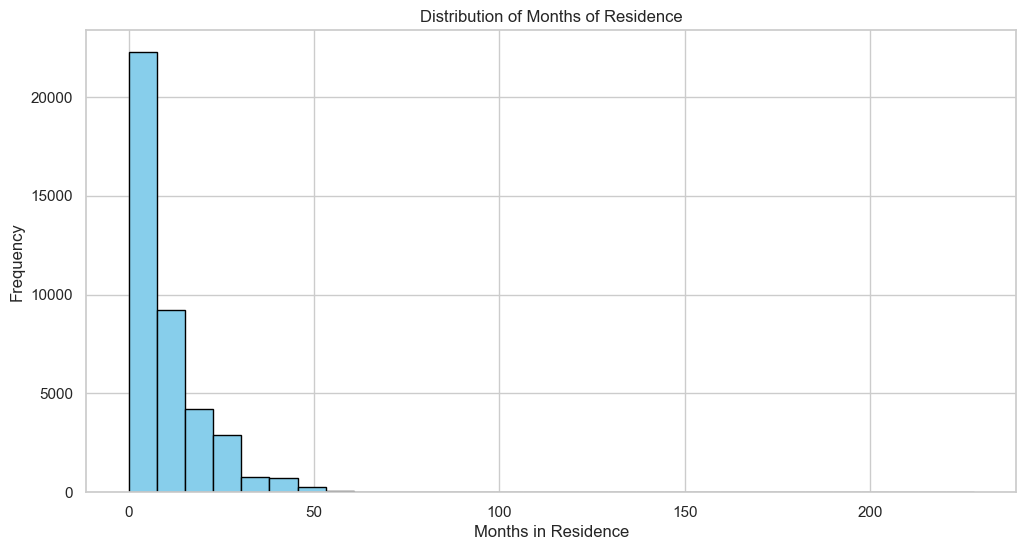

In [22]:
# Plot MONTHS_IN_RESIDENCE
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.hist(
    final_model["MONTHS_IN_RESIDENCE"].dropna(),
    bins=30,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Months of Residence")
plt.xlabel("Months in Residence")
plt.ylabel("Frequency")
plt.show()

In [23]:
# Log the Personal Monthly Income
# Adding a small constant (e.g., 1) to handle zero incomes
final_model["LOG_PERSONAL_MONTHLY_INCOME"] = np.log(
    final_model["PERSONAL_MONTHLY_INCOME"] + 1
)

In [24]:
# remove rows in Log Personal Monthly Income where the value is the string 'nan'
final_model = final_model[final_model["LOG_PERSONAL_MONTHLY_INCOME"] != "nan"]

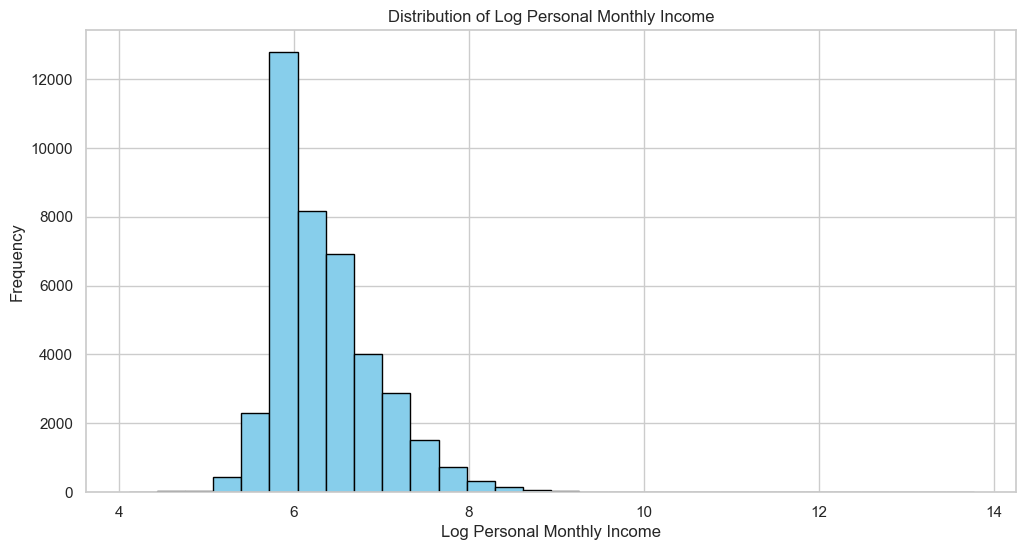

In [25]:
# Plotting the distribution of the new log-transformed variable
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.hist(
    final_model["LOG_PERSONAL_MONTHLY_INCOME"].dropna(),
    bins=30,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Log Personal Monthly Income")
plt.xlabel("Log Personal Monthly Income")
plt.ylabel("Frequency")

# Show the plot
plt.show()

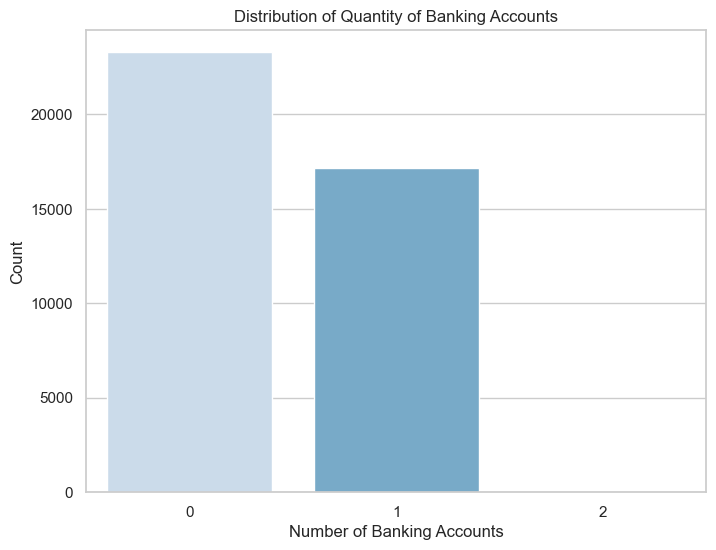

In [26]:
# Plotting the QUANT_BANKING_ACCOUNTS
sns.set(style="whitegrid")

# Plotting with seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x="QUANT_BANKING_ACCOUNTS", data=final_model, palette="Blues")
plt.title("Distribution of Quantity of Banking Accounts")
plt.xlabel("Number of Banking Accounts")
plt.ylabel("Count")

# Show the plot
plt.show()

In [27]:
count_equals_2 = (final_model["QUANT_BANKING_ACCOUNTS"] == 2).sum()
print(f"There are {count_equals_2} quantity of banking accounts equal 2.")

There are 14 quantity of banking accounts equal 2.


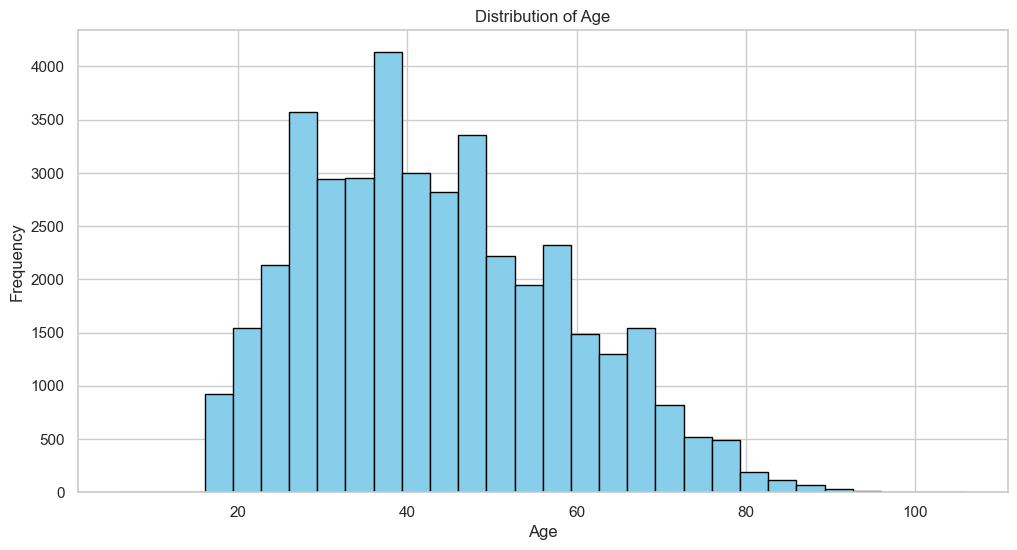

In [28]:
# Plotting AGE
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.hist(
    final_model["AGE"].dropna(),
    bins=30,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [29]:
# Clean the Sex variable
final_model = final_model[final_model["SEX"].isin(["F", "M"])]
final_model["SEX"].value_counts()

SEX
F    24814
M    15586
Name: count, dtype: int64

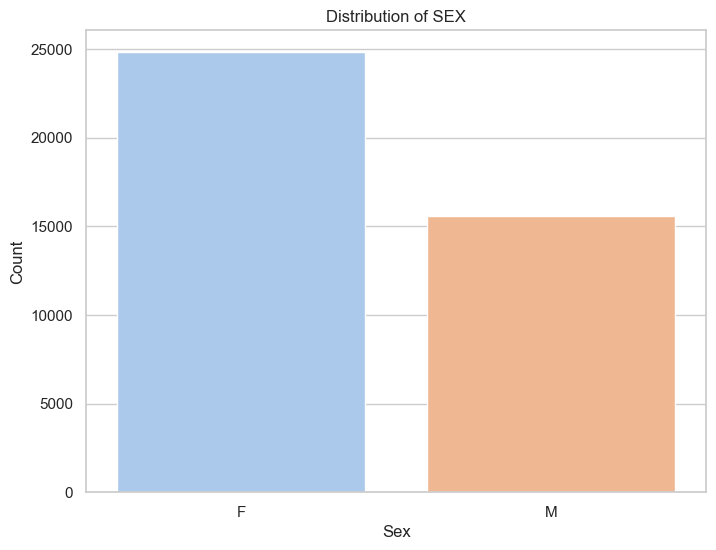

In [30]:
# Plotting Sex
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x="SEX", data=final_model, palette="pastel")
plt.title("Distribution of SEX")
plt.xlabel("Sex")
plt.ylabel("Count")

# Show the plot
plt.show()

Text(0, 0.5, 'Count')

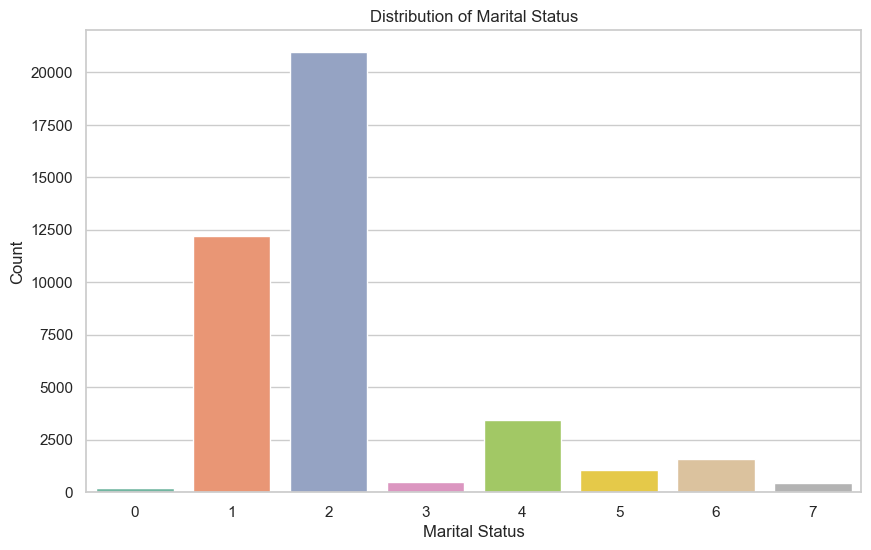

In [31]:
# Plotting Marriage Status
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x="MARITAL_STATUS", data=final_model, palette="Set2")
plt.title("Distribution of Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")

In [32]:
# remove rows in OCCUPATION_TYPE where the value is the string 'nan'
final_model = final_model[final_model["OCCUPATION_TYPE"] != "nan"]
final_model["OCCUPATION_TYPE"] = final_model["OCCUPATION_TYPE"].astype(int)

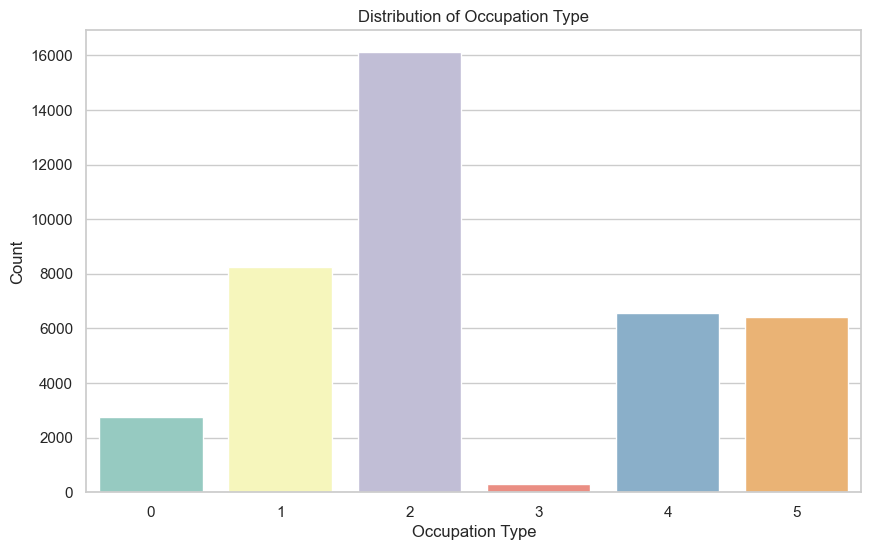

In [33]:
# Plotting Occupation Type
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x="OCCUPATION_TYPE", data=final_model, palette="Set3")
plt.title("Distribution of Occupation Type")
plt.xlabel("Occupation Type")
plt.ylabel("Count")

# Show the plot
plt.show()

In [34]:
# remove rows in RESIDENCE_TYPE where the value is the string 'nan'
final_model = final_model[final_model["RESIDENCE_TYPE"] != "nan"]
final_model["RESIDENCE_TYPE"] = final_model["RESIDENCE_TYPE"].astype(int)

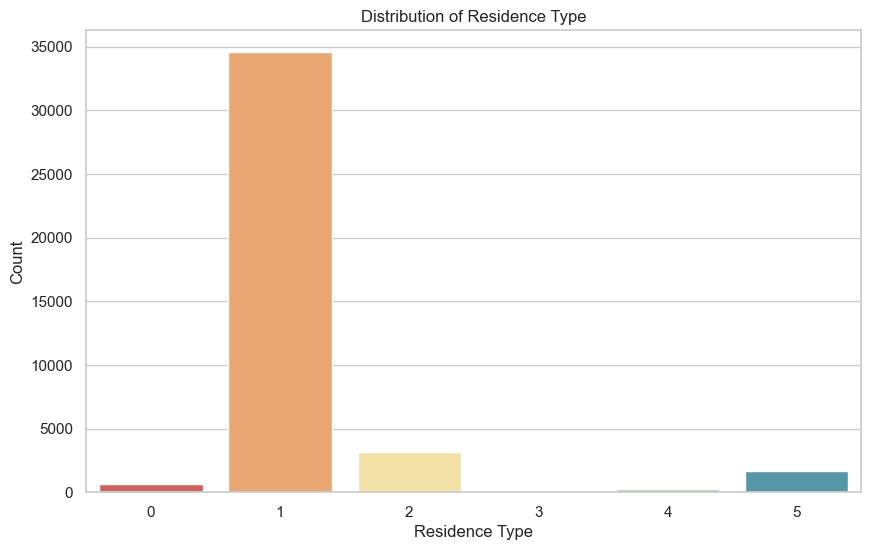

In [35]:
# Plotting RESIDENCE_TYPE
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x="RESIDENCE_TYPE", data=final_model, palette="Spectral")
plt.title("Distribution of Residence Type")
plt.xlabel("Residence Type")
plt.ylabel("Count")

# Show the plot
plt.show()

In [36]:
count_equals_3 = (final_model["RESIDENCE_TYPE"] == 3).sum()
print(f"There are {count_equals_3} quantity of residence type equal 3.")

There are 114 quantity of residence type equal 3.


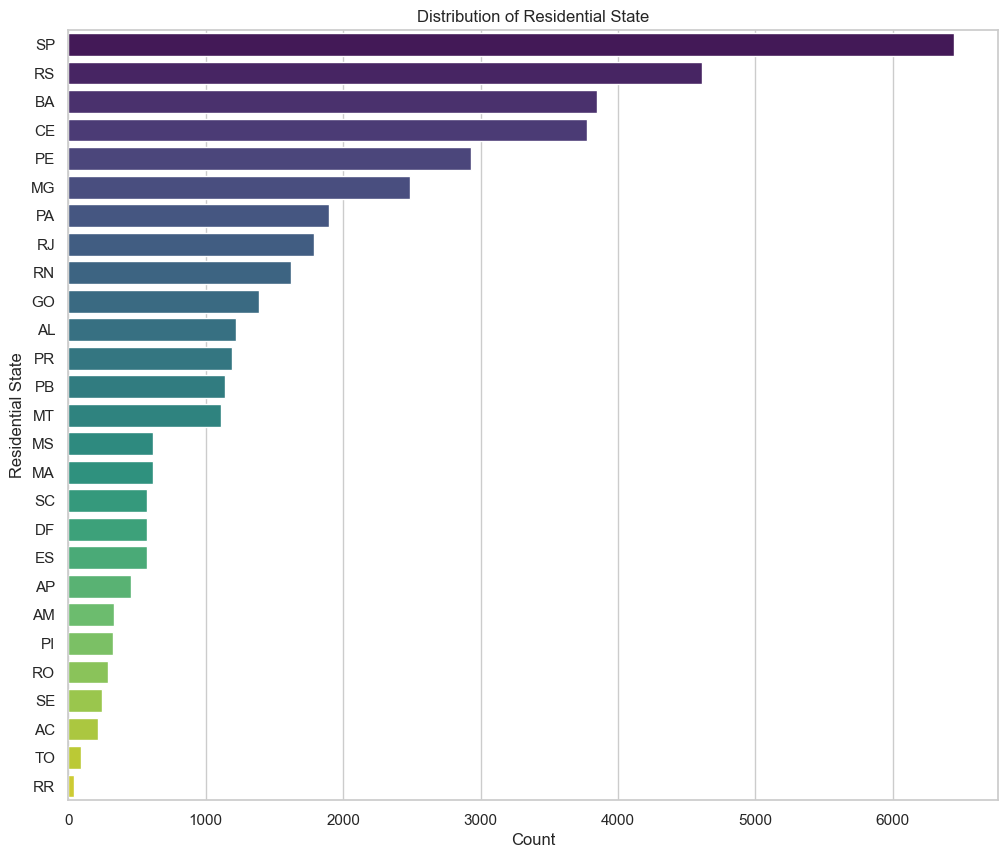

In [37]:
# Plotting RESIDENCIAL_STATE
sns.set(style="whitegrid")

plt.figure(figsize=(12, 10))
sns.countplot(
    y="RESIDENCIAL_STATE",
    data=final_model,
    palette="viridis",
    order=final_model["RESIDENCIAL_STATE"].value_counts().index,
)
plt.title("Distribution of Residential State")
plt.xlabel("Count")
plt.ylabel("Residential State")

# Show the plot
plt.show()

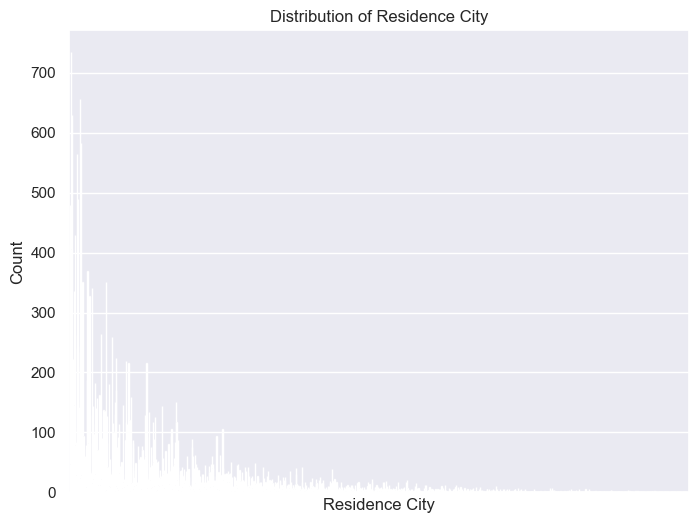

In [38]:
# Plotting RESIDENCIAL_CITY
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.countplot(data=final_model, x="RESIDENCIAL_CITY", palette="viridis")
plt.title("Distribution of Residence City")
plt.xlabel("Residence City")
plt.xticks([])
plt.ylabel("Count")
plt.show()

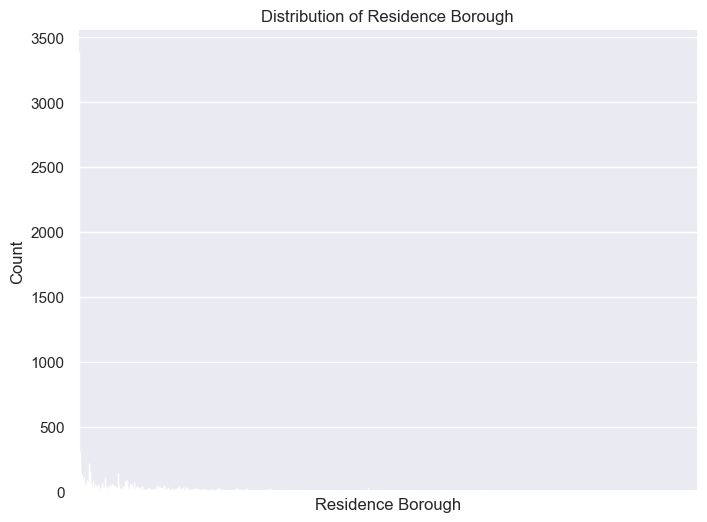

In [39]:
# Plotting RESIDENCIAL_BOUROUGH
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.countplot(data=final_model, x="RESIDENCIAL_BOROUGH", palette="viridis")
plt.title("Distribution of Residence Borough")
plt.xlabel("Residence Borough")
plt.xticks([])
plt.ylabel("Count")
plt.show()

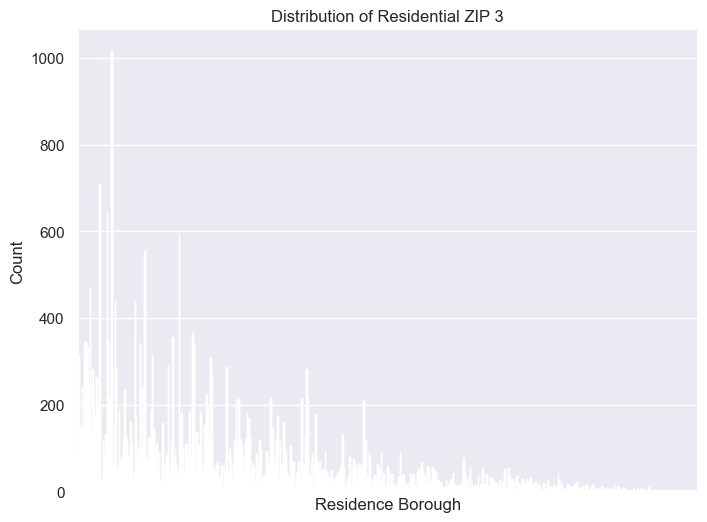

In [40]:
# Plotting RESIDENCIAL_ZIP_3
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.countplot(data=final_model, x="RESIDENCIAL_ZIP_3", palette="viridis")
plt.title("Distribution of Residential ZIP 3")
plt.xlabel("Residence Borough")
plt.xticks([])
plt.ylabel("Count")
plt.show()

> Distribution of Outcome Variable

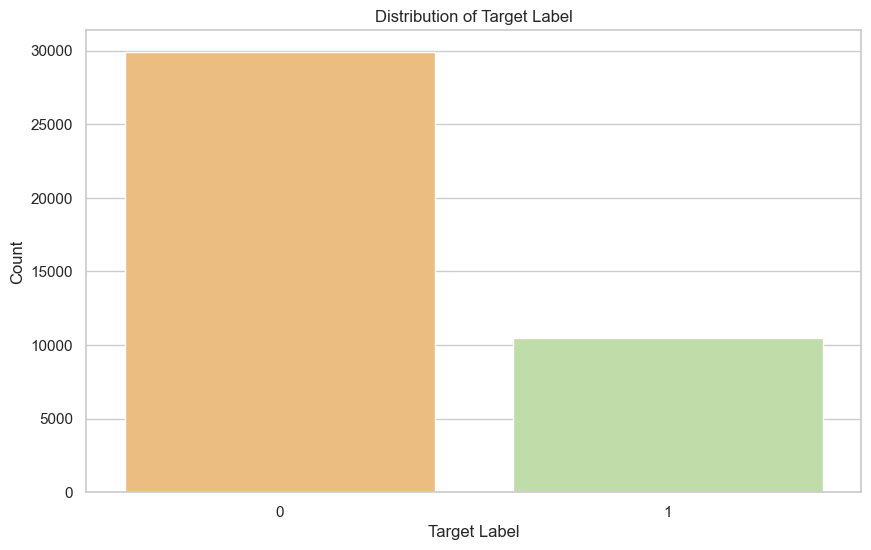

In [41]:
# Plotting target label
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x="TARGET_LABEL_BAD=1", data=final_model, palette="Spectral")
plt.title("Distribution of Target Label")
plt.xlabel("Target Label")
plt.ylabel("Count")

# Show the plot
plt.show()

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

> The problem with the three `RESIDENCIAL_` variables is that there are way to many unique categories in them, making them dirty strings that will pose problems later with model fitting.

In [42]:
residence = ["RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH", "RESIDENCIAL_STATE"]

# Drop these columns from the DataFrame
final_model = final_model.drop(columns=residence)

> Drop two old columns in the dataframe since we created new columns that transformed the variables through logging or regrouping.

In [43]:
old_columns = [
    "QUANT_DEPENDANTS",
    "PERSONAL_MONTHLY_INCOME",
]

# Drop these columns from the DataFrame
final_model = final_model.drop(columns=old_columns)

## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [45]:
# Drop residential zip column from the DataFrame
final_model = final_model.drop(columns="RESIDENCIAL_ZIP_3")

In [46]:
# Define X and y
X = final_model.drop(["TARGET_LABEL_BAD=1"], axis=1)
y = final_model["TARGET_LABEL_BAD=1"]

In [47]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [48]:
# Print the column names along with their indices in the final dataset
for index, column_name in enumerate(X_train.columns):
    print(f"Index: {index}, Column Name: '{column_name}'")

Index: 0, Column Name: 'QUANT_CARS'
Index: 1, Column Name: 'MONTHS_IN_RESIDENCE'
Index: 2, Column Name: 'QUANT_BANKING_ACCOUNTS'
Index: 3, Column Name: 'AGE'
Index: 4, Column Name: 'SEX'
Index: 5, Column Name: 'MARITAL_STATUS'
Index: 6, Column Name: 'OCCUPATION_TYPE'
Index: 7, Column Name: 'RESIDENCE_TYPE'
Index: 8, Column Name: 'NEW_QUANT_DEPENDANTS'
Index: 9, Column Name: 'LOG_PERSONAL_MONTHLY_INCOME'


In [49]:
# Function to check for the presence of strings in columns that should be numeric
def check_for_strings_in_numeric(df, column_name):
    # Check if the column data type is numeric (int or float)
    if df[column_name].dtype == "int64" or df[column_name].dtype == "float64":
        # Check for any entries that are stored as strings
        string_entries = df[column_name].apply(lambda x: isinstance(x, str)).sum()
        return string_entries
    else:
        # If the column is not intended to be numeric, return None
        return None


# Columns to check
columns_to_check = [
    "QUANT_CARS",
    "QUANT_BANKING_ACCOUNTS",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "TARGET_LABEL_BAD=1",
    "NEW_QUANT_DEPENDANTS",
    "MONTHS_IN_RESIDENCE",
    "LOG_PERSONAL_MONTHLY_INCOME",
    "AGE",
]

# Check each column and print the result
for column in columns_to_check:
    string_entries_count = check_for_strings_in_numeric(final_model, column)
    if string_entries_count is not None:
        print(f"Column: {column} has {string_entries_count} string entries.")
    else:
        print(f"Column: {column} is not intended to be numeric.")

Column: QUANT_CARS has 0 string entries.
Column: QUANT_BANKING_ACCOUNTS has 0 string entries.
Column: SEX is not intended to be numeric.
Column: MARITAL_STATUS has 0 string entries.
Column: OCCUPATION_TYPE has 0 string entries.
Column: RESIDENCE_TYPE has 0 string entries.
Column: TARGET_LABEL_BAD=1 has 0 string entries.
Column: NEW_QUANT_DEPENDANTS is not intended to be numeric.
Column: MONTHS_IN_RESIDENCE has 0 string entries.
Column: LOG_PERSONAL_MONTHLY_INCOME has 0 string entries.
Column: AGE has 0 string entries.


In [50]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
X_train["QUANT_CARS"] = label_encoder.fit_transform(X_train["QUANT_CARS"])
X_test["QUANT_CARS"] = label_encoder.transform(X_test["QUANT_CARS"])
X_train["QUANT_BANKING_ACCOUNTS"] = label_encoder.fit_transform(
    X_train["QUANT_BANKING_ACCOUNTS"]
)
X_test["QUANT_BANKING_ACCOUNTS"] = label_encoder.transform(
    X_test["QUANT_BANKING_ACCOUNTS"]
)
X_train["SEX"] = label_encoder.fit_transform(X_train["SEX"])
X_test["SEX"] = label_encoder.transform(X_test["SEX"])
X_train["MARITAL_STATUS"] = label_encoder.fit_transform(X_train["MARITAL_STATUS"])
X_test["MARITAL_STATUS"] = label_encoder.transform(X_test["MARITAL_STATUS"])
X_train["OCCUPATION_TYPE"] = label_encoder.fit_transform(X_train["OCCUPATION_TYPE"])
X_test["OCCUPATION_TYPE"] = label_encoder.transform(X_test["OCCUPATION_TYPE"])
X_train["RESIDENCE_TYPE"] = label_encoder.fit_transform(X_train["RESIDENCE_TYPE"])
X_test["RESIDENCE_TYPE"] = label_encoder.transform(X_test["RESIDENCE_TYPE"])
X_train["NEW_QUANT_DEPENDANTS"] = label_encoder.fit_transform(
    X_train["NEW_QUANT_DEPENDANTS"]
)
X_test["NEW_QUANT_DEPENDANTS"] = label_encoder.transform(X_test["NEW_QUANT_DEPENDANTS"])

In [51]:
gam = LogisticGAM(
    f(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + s(9)
).gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:35
 18% (2 of 11) |####                     | Elapsed Time: 0:00:05 ETA:   0:00:22
 27% (3 of 11) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:11
 36% (4 of 11) |#########                | Elapsed Time: 0:00:07 ETA:   0:00:08
 45% (5 of 11) |###########              | Elapsed Time: 0:00:08 ETA:   0:00:06
 54% (6 of 11) |#############            | Elapsed Time: 0:00:10 ETA:   0:00:06
 63% (7 of 11) |###############          | Elapsed Time: 0:00:11 ETA:   0:00:05
 72% (8 of 11) |##################       | Elapsed Time: 0:00:12 ETA:   0:00:03
 81% (9 of 11) |####################     | Elapsed Time: 0:00:13 ETA:   0:00:02
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:16 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

In [52]:
# make predictions and evaluate the model
y_pred = gam.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix format:
# [[True Negative (TN), False Positive (FP)],
#  [False Negative (FN), True Positive (TP)]]
conf_matrix

array([[5978,    0],
       [2101,    1]])

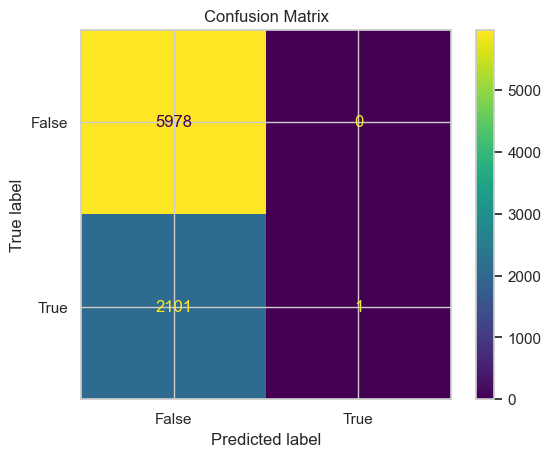

In [53]:
# visualize confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=[False, True]
)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

In [54]:
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate the number of "good bets" (True Negatives)
good_bets = TN

# Calculate "good bets" and False Omission Rate
good_bets = TN
false_omission_rate = FN / (TN + FN)

# compute model accuracy
# Calculating accuracy
accuracy = (TP + TN) / (TN + FP + FN + TP)

# Print the results
print(f"Number of 'good bets' (True Negatives): {good_bets}")
print(
    f"False Omission Rate (FOR): {false_omission_rate:.2f} or {false_omission_rate * 100:.2f}%"
)
print(f"Accuracy: {accuracy*100:.2f}%")

Number of 'good bets' (True Negatives): 5978
False Omission Rate (FOR): 0.26 or 26.01%
Accuracy: 74.00%


> The model has an overall high accruacy of 74%. Looking at the confusion matrix, the model maximizes accuracy by being very conservative, predicting nearly all instances as class 0 ("not bad"), thus failing to accurately identify the "bad" instances. This strategy appears to stem from the significant imbalance present within the dataset (more "not bad" label than "bad" label), which in turn compromises the model's ability to accurately detect "bad" instances. There is a high number of true negatives (5978) where it correctly identifies "not bad" instances, but it struggles significantly with the "bad" class, having a high number of false negatives (2101) and very few true positives (1), with a false omission rate is 26%. The model needs to enhance its sensitivity towards "bad" instances to achieve a more balanced and accurate predictive performance.

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

In [55]:
# Get predicted probabilities for the positive class
y_proba_positive = gam.predict_proba(X_test)

# Define a range of thresholds to explore
thresholds = np.linspace(0, 1, 101)

best_for = float("inf")
best_threshold = 0
best_tn = 0

for threshold in thresholds:
    # Apply threshold to predicted probabilities to classify as positive
    y_pred_threshold = (y_proba_positive >= threshold).astype(int)

    # Generate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    if TN > 10:
        # Calculate the False Omission Rate
        current_for = FN / (FN + TN) if (FN + TN) > 0 else 0

        if current_for < best_for:
            best_for = current_for
            best_threshold = threshold
            best_tn = TN

print(f"Best Threshold: {best_threshold}")
print(f"Number of 'good bets' (True Negatives) at this threshold: {best_tn}")
print(
    f"Lowest False Omission Rate (FOR) achieved: {best_for:.4f} or {best_for * 100:.2f}%"
)

Best Threshold: 0.15
Number of 'good bets' (True Negatives) at this threshold: 16
Lowest False Omission Rate (FOR) achieved: 0.1579 or 15.79%


### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

In [56]:
# Initialize variables to track the optimal performance within the FOR tolerance
optimal_tn_within_tolerance_for = 0
optimal_threshold_within_tolerance_for = 0
optimal_for = 0

for threshold in thresholds:
    # Apply threshold to predicted probabilities to make new predictions
    y_pred_threshold = (y_proba_positive >= threshold).astype(int)

    # Generate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Calculate the current False Omission Rate
    current_for = FN / (FN + TN) if (FN + TN) > 0 else 0

    # Check if the current FOR is within the tolerance and if TN is maximized
    if current_for <= 0.19 and TN > optimal_tn_within_tolerance_for:
        optimal_tn_within_tolerance_for = TN
        optimal_threshold_within_tolerance_for = threshold
        optimal_for = current_for

print(
    f"With a tolerance for a False Omission Rate of 19%, the maximum number of true negatives (good bets) the stakeholder can enroll is: {optimal_tn_within_tolerance_for}"
)
print(f"This is achieved with a threshold of: {optimal_threshold_within_tolerance_for}")
print(f"The actual False Omission Rate at this threshold is: {optimal_for * 100:.2f}%")

With a tolerance for a False Omission Rate of 19%, the maximum number of true negatives (good bets) the stakeholder can enroll is: 1809
This is achieved with a threshold of: 0.22
The actual False Omission Rate at this threshold is: 18.33%


## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

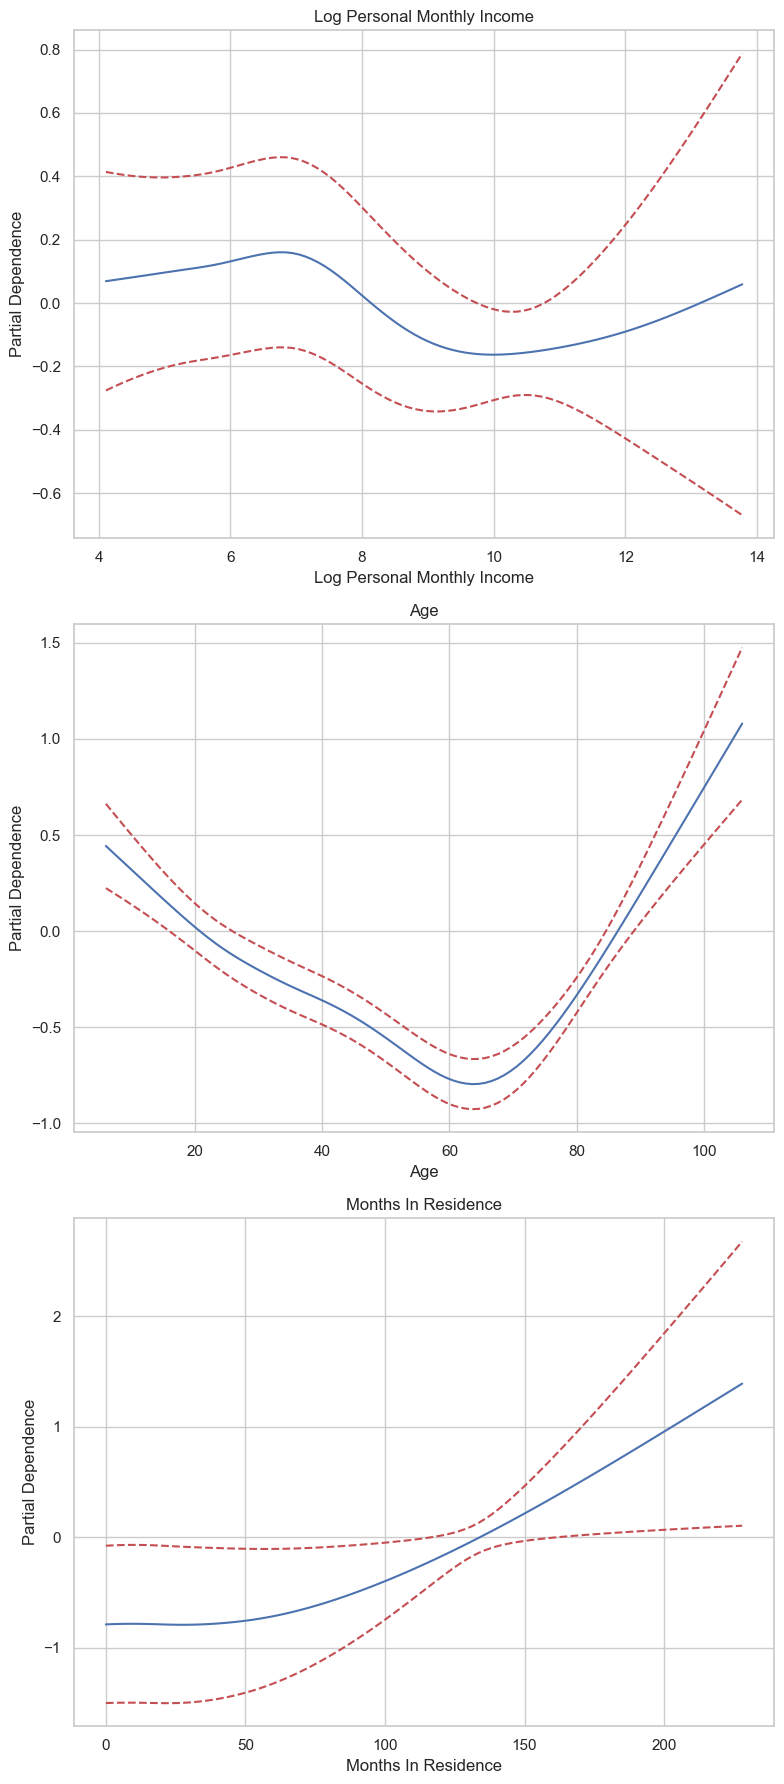

In [57]:
features_to_plot = ["LOG_PERSONAL_MONTHLY_INCOME", "AGE", "MONTHS_IN_RESIDENCE"]

feature_index_map = {
    "LOG_PERSONAL_MONTHLY_INCOME": 9,
    "AGE": 3,
    "MONTHS_IN_RESIDENCE": 1,
}

fig, axs = plt.subplots(len(features_to_plot), figsize=(8, 6 * len(features_to_plot)))

# Plot Partial Dependence for Continuous variables
for i, feature_name in enumerate(features_to_plot):
    feature_index = feature_index_map[feature_name]

    XX = gam.generate_X_grid(term=feature_index)
    pdep, confi = gam.partial_dependence(term=feature_index, width=0.95)

    ax = axs[i]
    ax.plot(XX[:, feature_index], pdep)
    ax.plot(XX[:, feature_index], confi, c="r", ls="--")

    # Convert feature_name to lowercase and replace underscores with spaces
    # Capitalize first letter
    formatted_feature_name = feature_name.lower().replace("_", " ").title()
    ax.set_title(formatted_feature_name)
    ax.set_xlabel(formatted_feature_name)
    ax.set_ylabel("Partial Dependence")

plt.tight_layout()
plt.show()

### Exercise 10

How does the partial correlation with respect to age look?

> The partial dependence plot visualizes the average predicted effect on the model's output of the feature 'Age', providing insight into the relationship between the target label for credit risk and the feature age. It shows a non-linear relationship: the effect decreases before age 60, indicating that the likelihood of the target of credit risk to be labeled as bad decreases as the person gets older before age 60. After age 60, the effect starts increasing with age, suggesting that the likelihood of the target of credit risk to be labeled as bad becomes more likely as age increases beyond age 60. The shape of the curve suggests that the youngest and the oldest age groups have a higher predicted value for the response variable compared to the middle-aged group. This reflect a U-shaped relationship where both very young and very old ages are associated with an increase in the predicted outcome of credit risk being labeled as bad, while middle age is associated with a decrease in the predicted outcome of credit risk being labeled as bad.

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

In [58]:
X_train["SEX"] = np.where(X_train["SEX"] == "F", 0, 1)

In [59]:
# Model with monotonic increasing constraint

gam1_mono = LogisticGAM(
    f(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + s(9),
    constraints="monotonic_inc",
).gridsearch(X_train.values, y_train.values)

# Model with concave constraint
gam1_concave = LogisticGAM(
    f(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + s(9),
    constraints="concave",
).gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:39
 18% (2 of 11) |####                     | Elapsed Time: 0:00:05 ETA:   0:00:24
 27% (3 of 11) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:10
 36% (4 of 11) |#########                | Elapsed Time: 0:00:07 ETA:   0:00:08
 45% (5 of 11) |###########              | Elapsed Time: 0:00:08 ETA:   0:00:06
 54% (6 of 11) |#############            | Elapsed Time: 0:00:10 ETA:   0:00:06
 63% (7 of 11) |###############          | Elapsed Time: 0:00:11 ETA:   0:00:05
 72% (8 of 11) |##################       | Elapsed Time: 0:00:14 ETA:   0:00:08
 81% (9 of 11) |####################     | Elapsed Time: 0:00:15 ETA:   0:00:04
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:16 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:18 Time:  0:00:18
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


 25% (1 of 4) |######                    | Elapsed Time: 0:00:02 ETA:   0:00:07
 50% (2 of 4) |#############             | Elapsed Time: 0:00:04 ETA:   0:00:04
 75% (3 of 4) |###################       | Elapsed Time: 0:00:06 ETA:   0:00:01
100% (4 of 4) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08


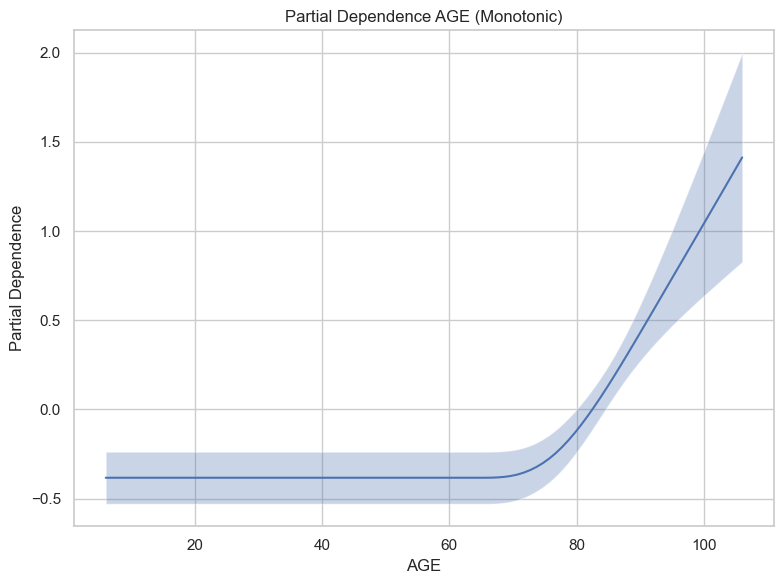

In [60]:
# Refit the model with monotonicity constraint
features = ["AGE"]

feature_index_map = {"AGE": 3}

lams = np.logspace(-3, 3, 4)
gam1_mono.gridsearch(X_train.values, y_train.values, lam=lams)

# Plot the new partial dependence
fig, ax = plt.subplots(figsize=(8, 6))

feature = features[0]  # Get the first feature which is "AGE"
i = feature_index_map[feature]
XX = gam1_mono.generate_X_grid(term=i)

# Set the 4th feature to 1 in the grid
XX[:, 4] = 1

pdep, confi = gam1_mono.partial_dependence(term=i, X=XX, width=0.95)
ax.plot(XX[:, i], pdep)
ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.3)
ax.set_xlabel(feature)
ax.set_ylabel("Partial Dependence")
ax.set_title(f"Partial Dependence {feature} (Monotonic)")

plt.tight_layout()
plt.show()

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:01 ETA:   0:00:04
 50% (2 of 4) |#############             | Elapsed Time: 0:00:02 ETA:   0:00:02
 75% (3 of 4) |###################       | Elapsed Time: 0:00:03 ETA:   0:00:01
100% (4 of 4) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


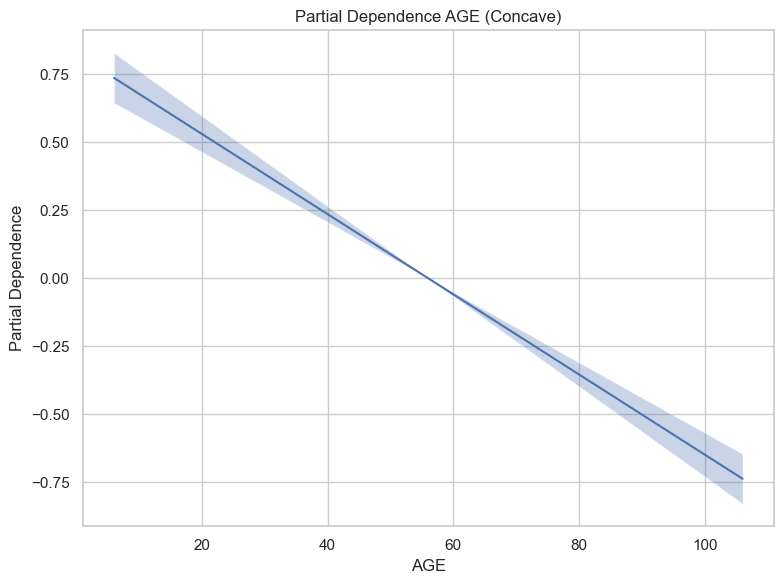

In [61]:
# Refit the model with concavity constraint
features = ["AGE"]

feature_index_map = {"AGE": 3}

lams = np.logspace(-3, 3, 4)
gam1_concave.gridsearch(X_train.values, y_train.values, lam=lams)

# Plot the new partial dependence
fig, ax = plt.subplots(figsize=(8, 6))

feature = features[0]  # Get the first feature which is "AGE"
i = feature_index_map[feature]
XX = gam1_concave.generate_X_grid(term=i)

# Set the 4th feature to 1 in the grid
XX[:, 4] = 1

pdep, confi = gam1_concave.partial_dependence(term=i, X=XX, width=0.95)
ax.plot(XX[:, i], pdep)
ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.3)
ax.set_xlabel(feature)
ax.set_ylabel("Partial Dependence")
ax.set_title(f"Partial Dependence {feature} (Concave)")

plt.tight_layout()
plt.show()

> - **Partial Dependence Plot with Monotonicity Constraint**: This plot suggests that before age 70, the likelihood of the target of credit risk to be labeled as bad stayed at a  constant low point as age increases. After age 70, the likelihood of the target of credit risk to be labeled as bad consistently increases. 
> - **Partial Dependence Plot with Concavity Constraint**: This plot suggests that the likelihood of the target of credit risk to be labeled as bad decreases at a constant rate as age increases. This could reflect a belief that as people get older, they get more savings and become more financially reliable.
> - The partial dependence plot with concavity constraint makes more sense since in the real world, younger age usually associates with higher credit risk.

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

In [62]:
X_test["SEX"] = np.where(X_test["SEX"] == "F", 0, 1)
y_pred_concave = gam1_concave.predict_proba(X_test)

# Define a range of thresholds to explore
thresholds = np.linspace(0, 1, 101)

best_for = float("inf")
best_threshold = 0
best_tn = 0

for threshold in thresholds:
    # Apply threshold to predicted probabilities to classify as positive
    y_pred_threshold = (y_pred_concave >= threshold).astype(int)

    # Generate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()

    if TN > 10:
        # Calculate the False Omission Rate
        current_for = FN / (FN + TN) if (FN + TN) > 0 else 0

        if current_for < best_for:
            best_for = current_for
            best_threshold = threshold
            best_tn = TN

print(f"Best Threshold: {best_threshold}")
print(f"Number of 'good bets' (True Negatives) at this threshold: {best_tn}")
print(
    f"Lowest False Omission Rate (FOR) achieved: {best_for:.4f} or {best_for * 100:.2f}%"
)

Best Threshold: 0.22
Number of 'good bets' (True Negatives) at this threshold: 1426
Lowest False Omission Rate (FOR) achieved: 0.1879 or 18.79%


>The number of true negatives we can have is 1426 for a false omission rate of 18.79%. Before we could have had 1809 true negatives for the false omission rate of 18.33%.

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

In [63]:
# random search
lams = np.random.rand(100, 10)  # random points with 10 features
lams = lams * 6 - 3  # shift values to -3, 3
lams = 10**lams

random_gam = LogisticGAM(
    f(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + s(9)
).gridsearch(X_train.values, y_train.values, lam=lams)

random_gam.summary()

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:42
  2% (2 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:03:49
  3% (3 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:03:26
  4% (4 of 100) |                        | Elapsed Time: 0:00:07 ETA:   0:02:38
  5% (5 of 100) |#                       | Elapsed Time: 0:00:09 ETA:   0:03:11
  6% (6 of 100) |#                       | Elapsed Time: 0:00:10 ETA:   0:02:22
  7% (7 of 100) |#                       | Elapsed Time: 0:00:11 ETA:   0:01:43
  8% (8 of 100) |#                       | Elapsed Time: 0:00:12 ETA:   0:02:02
  9% (9 of 100) |##                      | Elapsed Time: 0:00:14 ETA:   0:02:04
 10% (10 of 100) |##                     | Elapsed Time: 0:00:16 ETA:   0:03:08
 11% (11 of 100) |##                     | Elapsed Time: 0:00:17 ETA:   0:02:31
 12% (12 of 100) |##                     | Elapsed Time: 0:00:18 ETA:   0:01:36
 13% (13 of 100) |##                    

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     35.6869
Link Function:                        LogitLink Log Likelihood:                                -18195.5791
Number of Samples:                        32320 AIC:                                            36462.5321
                                                AICc:                                           36462.6177
                                                UBRE:                                               3.1291
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0172
Feature Function                  Lam

> The features "Age" (s(3)) and "Occupation Type" (f(6)) have high lambda values, implies stronger smoothing. The features "Quantity of Cars" (f(0)) and "Sex" (f(4)) are not statistically significant. Overall, most features included in the model have a statistically significant relationship with the response variable "Target Label", with varying degrees of smoothing applied. 

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

In [64]:
random_prob = random_gam.predict_proba(X_test)
best_threshold = None
max_tn = 0
acceptable_fnr = float("inf")

for threshold in np.linspace(0, 1, 101):
    y_pred_threshold = (random_prob >= threshold).astype(int)
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_threshold).ravel()
    FNR = FN / (FN + TN) if (FN + TN) > 0 else 0
    if TN > max_tn and FNR <= 0.19:
        best_threshold = threshold
        max_tn = TN
        acceptable_fnr = FNR

if best_threshold is not None:
    print(f"Best Threshold: {best_threshold}")
    print(f"Number of 'good bets' (True Negatives) at this threshold: {max_tn}")
    print(f"Lowest False Omission Rate (FOR) achieved: {acceptable_fnr * 100:.2f}%")

Best Threshold: 0.23
Number of 'good bets' (True Negatives) at this threshold: 2151
Lowest False Omission Rate (FOR) achieved: 18.86%


### Exercise 15

Add an interaction term between age and personal income.

In [85]:
# recode use cat.code to avoid illustration problems
categorical_columns = [
    "QUANT_CARS",
    "QUANT_BANKING_ACCOUNTS",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "NEW_QUANT_DEPENDANTS",
]

for col in categorical_columns:
    # Convert to 'category' data type
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

    # Recode the categorical variables to start from 0 using .cat.codes
    categories = (
        pd.concat([X_train[col], X_test[col]], ignore_index=True)
        .astype("category")
        .cat.categories
    )
    X_train[col] = pd.Categorical(X_train[col], categories=categories).codes
    X_test[col] = pd.Categorical(X_test[col], categories=categories).codes

In [86]:
from pygam import GAM, s, te

lams = np.logspace(-3, 3, 4)

# add interaction term between age and log income
gam_interact = LogisticGAM(
    f(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + s(9) + te(3, 9)
).gridsearch(X_train.values, y_train.values, lam=lams)
gam_interact.summary()

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:07 ETA:   0:00:23
 50% (2 of 4) |#############             | Elapsed Time: 0:00:13 ETA:   0:00:10
 75% (3 of 4) |###################       | Elapsed Time: 0:00:16 ETA:   0:00:03
100% (4 of 4) |##########################| Elapsed Time: 0:00:20 Time:  0:00:20


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     43.3108
Link Function:                        LogitLink Log Likelihood:                                -18173.9564
Number of Samples:                        32320 AIC:                                            36434.5344
                                                AICc:                                           36434.6588
                                                UBRE:                                               3.1284
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0184
Feature Function                  Lam

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams["figure.figsize"] = (12, 8)

Text(0.5, 0.92, 'Partial Dependence of Age and Personal Monthly Income')

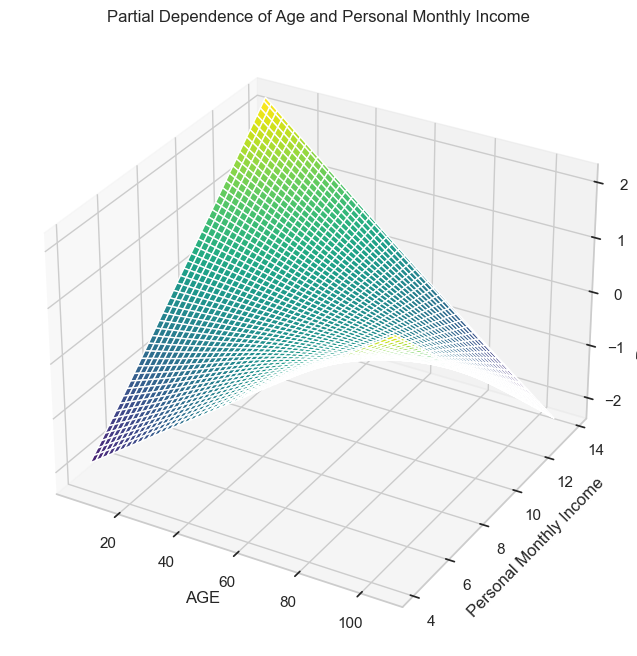

In [88]:
XX = gam_interact.generate_X_grid(term=10, meshgrid=True)
Z = gam_interact.partial_dependence(term=10, X=XX, meshgrid=True)

ax = plt.axes(projection="3d")
ax.plot_surface(XX[0], XX[1], Z, cmap="viridis")
ax.set_xlabel("AGE")
ax.set_ylabel("Personal Monthly Income")
ax.set_zlabel("Partial Dependence")
ax.set_title("Partial Dependence of Age and Personal Monthly Income")

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```

In [89]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ebm_global = ebm.explain_global()
    show(ebm_global)

    ebm_local = ebm.explain_local(X_train, y_train)
    show(ebm_local)

<!-- http://127.0.0.1:7001/11355251216/ -->

<!-- http://127.0.0.1:7001/10983710096/ -->